<a href="https://colab.research.google.com/github/TieuLang/Do_An_Nhan_Dang/blob/main/CS338_Ver2_Fruit_and_Vegetable_Image_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CS338 CAPSTONE PROJECT: FRUIT AND VEGETABLE RECOGNITION FROM IMAGE**

**Student name:**

**Quyet-Thang Nguyen - ID: 18520152**

**Gia-Huy Phan - ID: 18520068**

Dataset: [Fruit and Vegetable Image Recognition](https://www.kaggle.com/kritikseth/fruit-and-vegetable-image-recognition?fbclid=IwAR1q-q47RTQoXrzgEjbe99Rhg41RVu971ohOwJPZXnD4CDDhkOjeW7NjYcs)

## **MOUNT GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


## **Import Lib**

In [ ]:
import numpy as np
import time
import itertools
import os


import PIL.Image as Image
import requests
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub

from skimage.transform import resize
from io import BytesIO
from scipy import misc

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 2.5.0
Hub version: 0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [ ]:
print("[INFO] Check Accelerators Information: ")
!nvidia-smi

[INFO] Check Accelerators Information: 
Fri Jul 16 07:47:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    31W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

## **Download and Preprocessing data**

### **Get Dataset**

In [ ]:
print("Upload Kaggle authentication file: ")
from google.colab import files
files.upload()

Upload Kaggle authentication file: 


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thangnguyenquyet","key":"3ff12efd58a563b353d7cc78deaffcb5"}'}

In [ ]:
# Check current location, '/content' is the Colab virtual machine
os.getcwd()
# Make kaggle dir in this machine to save data
if not os.path.isdir('/content/kaggle'):
  os.mkdir('/content/kaggle')
# Navigate into direcory where you want to store your Kaggle data
os.chdir('/content/kaggle')
# Upload Kaggle authentication file
print("Upload Kaggle authentication file: ")
from google.colab import files
files.upload()
!chmod 600 /content/kaggle/kaggle.json
# Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
os.environ['KAGGLE_CONFIG_DIR'] = '/content/kaggle'

Upload Kaggle authentication file: 


Saving kaggle.json to kaggle.json


In [ ]:
# Download Kaggle API
!pip install -q kaggle

In [ ]:
# Paste and run the copied API command, the data will download to the current directory
!kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition
# Check contents of directory, you should see the .zip file for the competition in your Drive
os.listdir()

100% 2.18G/2.19G [00:28<00:00, 23.2MB/s]
100% 2.19G/2.19G [00:28<00:00, 81.2MB/s]


['fruit-and-vegetable-image-recognition.zip', 'kaggle.json']

In [ ]:
os.chdir('/content/kaggle')
!unzip -q '/content/kaggle/fruit-and-vegetable-image-recognition.zip'

In [ ]:
os.chdir('/content')

### **Select the TF2 SavedModel module (Outut: feature vector) to use**

In [ ]:
model_name = "mobilenet_v3_small_100_224" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/1",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/1",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/1",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/1",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/1",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/1",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/1",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/1",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/1",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/1",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/1",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/1",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/1",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE =  16#@param {type:"integer"}

Selected model: mobilenet_v3_small_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5
Input size (224, 224)


### **Preprocessing Dataset**

In [ ]:
def build_dataset(subset, data_dir, split = True):
  if split:
    return keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.20,
        subset=subset,
        label_mode="categorical",
        # Seed needs to provided when using validation_split and shuffle = True.
        # A fixed seed is used so that the validation set is stable across runs.
        seed=123,
        image_size=IMAGE_SIZE,
        batch_size=1)
  else:
    return keras.preprocessing.image_dataset_from_directory(
        data_dir,
        label_mode="categorical",
        image_size=IMAGE_SIZE,
        batch_size=1)    

**Build Train dataset**

In [ ]:
train_data_dir = "/content/kaggle/train"
train_ds = build_dataset("training", train_data_dir, split = False)
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()
print(f"Number class: {len(class_names)}")
print(f"Class names: \n{class_names}")
print(f"Train size: {train_size}")

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(
    1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      layers.experimental.preprocessing.RandomRotation(40))
  preprocessing_model.add(
      layers.experimental.preprocessing.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      layers.experimental.preprocessing.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      layers.experimental.preprocessing.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      layers.experimental.preprocessing.RandomFlip(mode="horizontal"))
  
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

**Build Validation dataset**

In [ ]:
val_data_dir = "/content/kaggle/validation"
val_ds = build_dataset("validation", val_data_dir, split = False)
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

print(f"Validation size: {valid_size}")

**Build Test dataset**

In [ ]:
test_data_dir = "/content/kaggle/test"
test_ds = build_dataset("testing", test_data_dir, split = False)
test_size = test_ds.cardinality().numpy()
test_ds = test_ds.unbatch().batch(BATCH_SIZE)
test_ds = test_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))
print(f"Test size: {test_size}")

## **TRANSFER LEARNING CLASSIFY MODEL**

In [ ]:
del model
del evaluate_model

###  **DEFINE MODEL ARCHITECTURE**

In [ ]:
do_fine_tuning = True #@param {type:"boolean"}
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

### **TRAINING MODEL**

**Set optimize strategy, loss function for class classify problem**

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

**Set callbacks function to save checkpoint every epoch**

In [ ]:
checkpoint_basedir = '/gdrive/MyDrive/CS338_NhanDang/MobileNet_2'
# Include the epoch in the file name (uses `str.format`)
checkpoint_dir_path = os.path.join(checkpoint_basedir, model_name + '_checkpoint')
checkpoint_file_path = os.path.join(checkpoint_dir_path, 'cp-{epoch:04d}.ckpt')
if not os.path.exists(checkpoint_dir_path):
  os.makedirs(checkpoint_dir_path)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=False,
    save_freq='epoch',
    verbose=1)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_file_path.format(epoch=0))

**Start train process**

In [ ]:
number_epochs =  30#@param {type: "integer"}
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=number_epochs, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint_callback]).history

**Visualize Training Process**

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,4])
plt.plot(hist["loss"], 'r', label='train')
plt.plot(hist["val_loss"], 'b', label='valid')
plt.show()
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], 'r', label='train')
plt.plot(hist["val_accuracy"], 'b', label='valid')
plt.show()

**Evaluate trained model in test set**

In [ ]:
test_steps = test_size // BATCH_SIZE
test_loss, test_accuracy = model.evaluate(test_ds, steps=test_steps, verbose=True)
print(f"[INFO] Loss in test set: {test_loss}")
print(f"[INFO] Accuracy in test set: {test_accuracy}")

## **SAVE ENVIROMENT AND RESULT**

In [ ]:
!rm -R '/content/tmp/mobilenet_v3_small_100_224'

In [ ]:
save_basedir = '/gdrive/MyDrive/CS338_NhanDang/MobileNet_2/Report'
save_dir_path = os.path.join(save_basedir, model_name)
if not os.path.exists(save_dir_path):
  os.makedirs(save_dir_path)

env_file_path = os.path.join(save_dir_path, 'env.txt')
result_file_path = os.path.join(save_dir_path, 'report.txt')

# Write Enviroment file
with open(env_file_path, 'w') as f:
  f.write(f'Numpy version: {np.__version__} \n')
  f.write(f'matplotlib version: {plt.__version__} \n')
  f.write(f'Tensorflow version: {tf.__version__} \n')
  f.write(f'Tensorflow Hub: {hub.__version__}')

import datetime

# Write Result file
with open(result_file_path, 'w') as f:
  f.write(f"EXPERIMENT DATE {datetime.datetime.now()}\n")
  f.write(f"Model Backbone: {model_handle}\n")
  f.write(f"Model Architecture: \n")
  model.summary(print_fn=lambda x: f.write(x + '\n\n'))

  f.write(f"TRAINING INFO: \n")
  for epoch in range(number_epochs):
    f.write(f"Epoch {epoch + 1}: \nloss: {hist['loss'][epoch]} \naccuracy: {hist['accuracy'][epoch]} \nvalidation loss: {hist['val_loss'][epoch]} \nvalidation accuracy: {hist['val_accuracy'][epoch]}\n\n")
  
  f.write(f"EVALUATE ON TEST SET: \n")
  f.write(f"Loss: {test_loss} \n")
  f.write(f"Accuracy: {test_accuracy} \n")

# Save training histogram 
loss_image_path = os.path.join(save_dir_path, 'training_process_loss.png')
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,4])
plt.plot(hist["loss"], 'r', label='train')
plt.plot(hist["val_loss"], 'b', label='valid')
plt.savefig(loss_image_path)

acc_image_path = os.path.join(save_dir_path, 'training_process_acc.png')
plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], 'r', label='train')
plt.plot(hist["val_accuracy"], 'b', label='valid')
plt.savefig(acc_image_path)

## **DEPLOY TO Tensorflow Lite**

[TensorFlow Lite](https://www.tensorflow.org/lite) lets you deploy TensorFlow models to mobile and IoT devices. The code below shows how to convert the trained model to TF Lite and apply post-training tools from the [TensorFlow Model Optimization Toolkit](https://www.tensorflow.org/model_optimization). Finally, it runs it in the TF Lite Interpreter to examine the resulting quality

* Converting without optimization provides the same results as before (up to roundoff error).
* Converting with optimization without any data quantizes the model weights to 8 bits, but inference still uses floating-point computation for the neural network activations. This reduces model size almost by a factor of 4 and improves CPU latency on mobile devices.
* On top, computation of the neural network activations can be quantized to 8-bit integers as well if a small reference dataset is provided to calibrate the quantization range. On a mobile device, this accelerates inference further and makes it possible to run on accelerators like EdgeTPU.


### **Clone model architecture to load weight and evaluate on test set**

In [ ]:
del eval_model

In [ ]:
load_epoch = 14#@param {type:"integer"}
cp_eval_path = f"/gdrive/MyDrive/CS338_NhanDang/MobileNet/mobilenet_v3_small_100_224_checkpoint/cp-00{load_epoch}.ckpt"
eval_model = tf.keras.models.clone_model(model)
eval_model.summary()
eval_model.load_weights(cp_eval_path)
load_test_loss, load_test_accuracy = model.evaluate(test_ds, steps=test_steps, verbose=True)



### **Saved choose model (TF format) to convert TF lite**

In [ ]:
saved_model_path = f"/gdrive/MyDrive/CS338_NhanDang/MobileNet/{model_name}_epoch_14"
tf.saved_model.save(eval_model, saved_model_path)

**Load saved model to evaluate in test set**

In [ ]:
del new_model

In [ ]:
new_model = tf.keras.models.load_model('/gdrive/MyDrive/CS338_NhanDang/MobileNet/mobilenet_v3_small_100_224_epoch_14')

# Check its architecture
new_model.summary()

new_model_test_loss, new_model_test_accuracy = model.evaluate(test_ds, steps=test_steps, verbose=True)


### **Convert Saved model to TF lite model**

In [ ]:
#@title Optimization settings
optimize_lite_model = False  #@param {type:"boolean"}
#@markdown Setting a value greater than zero enables quantization of neural network activations. A few dozen is already a useful amount.
num_calibration_examples = 60  #@param {type:"slider", min:0, max:1000, step:1}
representative_dataset = None
if optimize_lite_model and num_calibration_examples:
  # Use a bounded number of training examples without labels for calibration.
  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

lite_model_path = f"/gdrive/MyDrive/CS338_NhanDang/MobileNet/TFLite_file/lite_model_{model_name}_v3_epoch_14.tflite"
with open(lite_model_path, "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))

Wrote TFLite model of 6252644 bytes.


In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)
# This little helper wraps the TF Lite interpreter as a numpy-to-numpy function.
def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

**Test TF lite model on test set**

In [ ]:
#@markdown For rapid experimentation, start with a moderate number of examples.
num_eval_examples = 100  #@param {type:"slider", min:0, max:300}
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in test_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TF Lite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TF Lite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

TF Lite model agrees with original model on 95 of 100 examples (95%).
TF Lite model is accurate on 99 of 100 examples (99%).


## **Test New Image**

In [ ]:
def load_image(url): 
    res = requests.get(url)
    if res.status_code == 200 and 'jpeg' in res.headers['content-type']:
        img_arr = np.array(Image.open(BytesIO(res.content)))
        return img_arr
    else: 
        return None

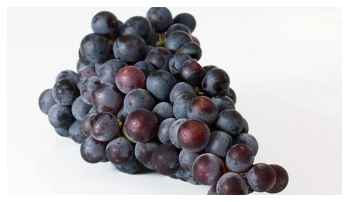

IMAGE SHAPE: (374, 666, 3)
RESIZE IMAGE TO (224, 224, 3)


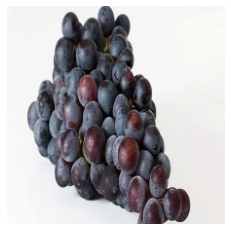

In [ ]:
url = 'https://photo-cms-viettimes.zadn.vn/666x374/Uploaded/2021/ovhipuo/2019_11_26/1nho_den_6677263_26112019.jpg' #@param {type:"string"}
true_label = 'Nho' #@param {type:"string"}

new_image = load_image(url)
if isinstance(new_image, np.ndarray):
  plt.imshow(new_image)
  plt.axis('off')
  plt.show()
  print(f"IMAGE SHAPE: {new_image.shape}")
  new_image = resize(new_image, IMAGE_SIZE)
  print(f"RESIZE IMAGE TO {new_image.shape}")
  plt.imshow(new_image)
  plt.axis('off')
  plt.show()
else:
  print("[INFO] Load image fail")

### **Saved model**

In [ ]:
saved_prediction_scores = new_model.predict(np.expand_dims(new_image, axis=0))
saved_predicted_index = np.argmax(saved_prediction_scores)
print(f"[INFO] Predicted label: {class_names[saved_predicted_index]}")

[INFO] Predicted label: grapes


### **TF lite model**

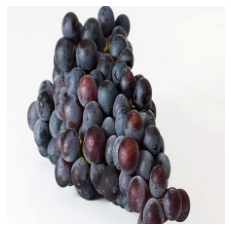

In [ ]:
# Convert type image from float64 to float32
new_image_float32 = new_image.astype('float32')
new_image_float32.dtype
plt.imshow(new_image_float32)
plt.axis('off')
plt.show()

In [ ]:
tflite_prediction_scores = lite_model(np.expand_dims(new_image_float32, axis=0))
tflite_predicted_index = np.argmax(tflite_prediction_scores)
print(f"[INFO] Predicted label: {class_names[tflite_predicted_index]}")

[INFO] Predicted label: grapes
